# Comparison of two independent sample means
In this notebook we will compare the mean of two independant samples by applying the $t$-test. The data can be found in the file *growth.csv* and consist in measures of the effect of two agricultural treatments on crop growth, compared to the control treatment. Crop growth was recorded as weight and was measured in 30 plots.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from math import sqrt
from scipy.stats import t, f, probplot, shapiro

In [2]:
#import data and remove first column which is a numerical index
growth = pd.read_csv("growth.csv").iloc[:, 1:]

#show column names
print("The column names are:")
for i in range(len(growth.columns)):
    print("{}".format(growth.columns[i]))

#show names of groups
print("\nThe group names are:")
for i in range(len(set(growth["group"]))):
    print("{}".format(list(set(growth["group"]))[i]))

The column names are:
weight
group

The group names are:
trt2
ctrl
trt1


To test the null hypothesis that a treatment modifies plant growth, we will compare the mean weight of plants in *treatment 2* (*trt2*) *vs* the *control* treatment (*ctrl*). The null hypothesis is that *control* and *treatment 2* give the same mean weight, the alternative hypothesis is that the mean weight is different between the two conditions. The two-independent samples t-test assumes that:
* treatments are performed on plots at random
* data from each treatment are normally distributed with the same variance
* plots receiving the same treatment are independent

The first and third assumptions are controlled by experimental design. Let's check normality and homoscedasticity (same variance) of samples.

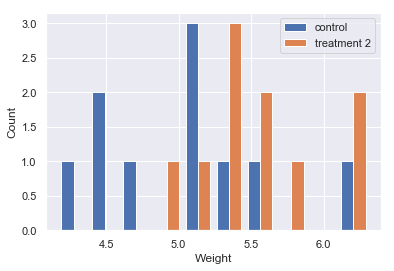

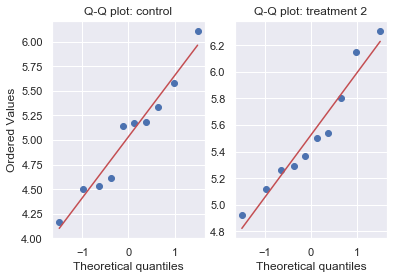

Shapiro-Wilk test for the control sample (W = 0.9567, p-value = 0.7475).
Shapiro-Wilk test for the treatment 2 sample (W = 0.9410, p-value = 0.5643).


In [3]:
#extract data from dataframe
ctrl = growth["weight"][growth["group"] == "ctrl"]
trt2 = growth["weight"][growth["group"] == "trt2"]

#plot histograms
fig, ax = plt.subplots()
ax.hist([ctrl, trt2], color=["C0", "C1"], label=["control", "treatment 2"])
ax.set_xlabel("Weight")
ax.set_ylabel("Count")
ax.legend()
plt.show()

#make qqplots
fig, axes = plt.subplots(nrows=1, ncols=2)
ax0, ax1 = axes.flatten()
qq_ctrl = probplot(ctrl, plot=ax0)
ax0.set_title("Q-Q plot: control")
qq_trt2 = probplot(trt2, plot=ax1)
ax1.set_title("Q-Q plot: treatment 2")
ax1.set_ylabel("")
plt.show()

#perform Shapiro-Wilk test
W1, p1 = shapiro(ctrl)
print("Shapiro-Wilk test for the control sample (W = {0:.4f}, p-value = {1:.4f}).".format(W1, p1))
    
W2, p2 = shapiro(trt2)
print("Shapiro-Wilk test for the treatment 2 sample (W = {0:.4f}, p-value = {1:.4f}).".format(W2, p2))

The distribution of the *control* and *treatment 2* samples do not differ significantly from normality. Let's now check the equality of variances. We calculate a **variance ratio** by dividing the larger $s^2$ by the smallest $s^2$. This number is then compared to the critical value for an **$F$-distribution**.

In [4]:
#perform F-test
def f_test(a, b):
    """Perform F-test on samples a and b."""
    #calculate parameters
    n_a = len(a)
    n_b = len(b)
    s_a = np.std(a, ddof=1)
    s_b = np.std(b, ddof=1)
    
    #calculate variance ratio
    if s_a > s_b:
        vr = s_a ** 2 / s_b ** 2
    else:
        vr = s_b ** 2 / s_a ** 2
    
    #calculate degrees of freedom
    if n_a > n_b :
        dfn, dfd = n_a - 1, n_b - 1
    else:
        dfd, dfn = n_b - 1, n_a - 1
        
    #calculate p-value
    p_val = 2 * (1 - f.cdf(vr, dfn, dfd))
    
    return vr, p_val

result_f = f_test(ctrl, trt2)
print("Result of the F-test for samples \"Control\" and \"Treatment 2\":")
print("F = {0:.3f}, p-value = {1:.3f}".format(result_f[0], result_f[1]))

Result of the F-test for samples "Control" and "Treatment 2":
F = 1.736, p-value = 0.424


If the variances cannot be considered equal (p-value < 0.05), we have to adjust the degrees of freedom and we cannot pool the sample variances. Let's first present calculations for the case when variances can be considered equal, then the slightly more complicated calculations when in the alternative case.

The **degrees of freedom** (df) for the t-test are found by adding the degrees of freedom for each sample: 
$$df = (n_1 - 1) + (n_2 - 1) = n_1 + n_2 - 2$$

The **$t$-value** is calculated by dividing the difference between the two sample means by their **standard error of difference** between the two means (SED): $$t = \frac{\bar{x_1} - \bar{x_2}}{SED}$$

The SED is calculated as follows: $$SED = \sqrt{s_p^2(\frac{1}{n_1}+\frac{1}{n_2})} = \sqrt{s_p^2(\frac{n_1 + n_2}{n_1 \times n_2})}$$

$s_p^2$ is the **pooled estimate of the assumed common population variance**, a weighted average of the two $s^2$ values: $$s_p^2 = \frac{Sxx_1 + Sxx_2}{df}$$

where $Sxx$ is the **sum of square deviations from the sample mean**: $$Sxx = \sum(x - \bar{x})^2 = (n - 1)s^2$$

We saw above that we cannot consider as equal the variances of *control* and *treatment 2*. In this case, we cannot pool the two variances estimates and the $t$-value must be calculated as follows: 
$$t = \frac{\bar{x_1} - \bar{x_2}} {\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

For small samples ($n < 30$), the degrees of freedom also have to be adjusted:
$$df = \frac{(\nu_1 + \nu_2)^2}{(\frac{\nu_1^2}{n_1 - 1} + \frac{\nu_2^2}{n_2 - 1})}$$
where $\nu_1 = s_1^2 / n_1$ and $\nu_2 = s_2^2 / n_2$.

Let's use these formulas to perform a two-independant sample t-test.

In [6]:
#definition of t-test function
def two_sample_ttest(a, b):
    """Perform a two-sample t-test on samples a and b"""
    #useful parameters
    n_a = len(a)
    n_b = len(b)
    s_a = np.std(a, ddof=1)
    s_b = np.std(b, ddof=1)
    
    #check homoscedasticity
    ftest = f_test(a, b)[1]
    
    #means
    x_a = np.mean(a)
    x_b = np.mean(b)
    
    if ftest >= 0.05:
        #degrees of freedom
        d_f = n_a + n_b - 2

        #variation parameters
        Sxx_a = s_a ** 2 * (n_a - 1)
        Sxx_b = s_b ** 2 * (n_b - 1)
        sp2 = (Sxx_a + Sxx_b) / d_f
        SED = sqrt(sp2 * (n_a + n_b) / (n_a * n_b))

        #critical values from t-distribution for difference of means
        crit = [t.ppf(0.025, df=d_f), t.ppf(0.975, df=d_f)]

        #95 % confidence interval for difference
        ci = [x_a - x_b + value * SED for value in crit]

        #t-value
        t_val = (x_a - x_b) / SED
        
        #p-value
        p_val = 2 * (1 - t.cdf(abs(t_val), df=d_f))

        #print results (Minitab style)
        print("Two sample t-test for weight\n")
        print("{0:11}{1:>10}{2:>10}{3:>10}{4:>10}".format("Group", "Size", "Mean", "StDev", "SE Mean"))
        print("{0:11}{1:10}{2:10.3f}{3:10.3f}{4:10.3f}".format("Control", n_a, x_a, s_a, s_a/sqrt(n_a)))
        print("{0:11}{1:10}{2:10.3f}{3:10.3f}{4:10.3f}".format("Treatment 2", n_b, x_b, s_b, s_b/sqrt(n_b)))
        print("\n95 % CI for difference of means: ({0:.3f}, {1:.3f})".format(ci[0], ci[1]))
        print("t-test mean(control) = mean(treatment 2)  (vs not =): \
t-value = {0:.3f}, p-value = {1:.4f}, df = {2}".format(t_val, p_val, d_f))
        print("Both used pooled StDev = {:.3f}".format(sqrt(sp2)))
        
    else:
        #calculate degrees of freedom
        nu_a = s_a ** 2 / n_a
        nu_b = s_b ** 2 / n_b
        d_f = (nu_a + nu_b) ** 2 / (nu_a ** 2 / (n_a - 1) + nu_b ** 2 / (n_b - 1))
        
        #calculate t-value
        t_val = (x_a - x_b) / sqrt(s_a ** 2 / n_a + s_b ** 2 / n_b)
        
        #p-value
        p_val = 2 * (1 - t.cdf(abs(t_val), df=d_f))
        
        print("Two sample t-test for weight\n")
        print("{0:11}{1:>10}{2:>10}{3:>10}{4:>10}".format("Group", "Size", "Mean", "StDev", "SE Mean"))
        print("{0:11}{1:10}{2:10.3f}{3:10.3f}{4:10.3f}".format("Control", n_a, x_a, s_a, s_a/sqrt(n_a)))
        print("{0:11}{1:10}{2:10.3f}{3:10.3f}{4:10.3f}".format("Treatment 2", n_b, x_b, s_b, s_b/sqrt(n_b)))
        print("\nt-test mean(control) = mean(treatment 2)  (vs not =): \
t-value = {0:.3f}, p-value = {1:.4f}, df = {2:.3f}".format(t_val, p_val, d_f))
        print("Variances are not equal, F-test p-value = {:.4f}".format(ftest))
        
#perform t-test
two_sample_ttest(ctrl, trt2)

Two sample t-test for weight

Group            Size      Mean     StDev   SE Mean
Control            10     5.032     0.583     0.184
Treatment 2        10     5.526     0.443     0.140

95 % CI for difference of means: (-0.980, -0.008)
t-test mean(control) = mean(treatment 2)  (vs not =): t-value = 2.134, p-value = 0.0469, df = 18
Both used pooled StDev = 0.518


## Determination of sample size for a given precision
Suppose we wish to compare two treatments. How many replicates per treatment do we need if we would like to detect a difference in mean of $\delta$ at a 5 % significance level? The number $r$ of replicates per treament (i.e. the sample size) is calculated such that: $$t \times \sqrt{\frac{2 \times \sigma ^2}{r}} < \delta$$ 
In other words: $$r > \frac{2 t ^2 \sigma ^2}{\delta ^2}$$
where $t$ it the $t$-value.

Let's use our previous example and say we would like to be able to detect a difference in mean of $1$. $\sigma^2$ is not known but will be approximated by using $s_p^2$. Finally, $t$ depends on the sample size but 2 is a good approximation for a significance level of 5 %.

In [19]:
Sxx_a = np.std(ctrl, ddof=1) ** 2 * (len(ctrl) - 1)
Sxx_b = np.std(trt2, ddof=1) ** 2 * (len(trt2) - 1)
sp2 = (Sxx_a + Sxx_b) / (len(ctrl) + len(trt2) - 2)
t_val = 2
delta = 1
r = round(2 * t_val **2 * sp2 / delta **2)
print("The minimum number of replicates to find a difference of {0} between the means is {1:.0f}.".format(delta, r))

The minimum number of replicates to find a difference of 1 between the means is 2.
